## Predición de Enfermedad Coronaria con Redes Neuronales

#### Objetivos

El objetivo del presente análisis es desarrollar un modelo que permita predecir si un paciente presenta un cuadro de enfermedad de arterias coronarias.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

#### Exploración de datos

Se procederá a cargar los datos y realizar una exploración preliminar para tener una noción de las características del conjunto de datos.

In [3]:
#loading the data set
data_path = os.path.join(os.getcwd(), '../data/heart.csv')
df = pd.read_csv(data_path)
#df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


*Output* es la variable objetivo. Se considera que el paciente tiene enfermedad coronaria si el estrechamiento de la  arteria en cuestión supera el 50% del diametro original observado en angiografía. Se da un valor de 1 si el paciente supera este límite (si tiene la enfermedad) y 0 en caso contrario. 

Los datos seleccionados fueron descargados de Kaggle bajo el nombre "Heart Attack Analysis & Prediction Dataset" y fueron subidos por Rashik Rahman. Este conjunto de datos cuenta con 303 observaciones.
Las características del conjunto de datos son las siguientes:

Edad: edad del paciente
.
Sexo: sexo del paciente. (0 = femenino, 1 = masculino)

cp: tipo de dolor de pecho. Valor 0: angina típica, Valor 1: angina atípica, Valor 2: dolor no anginoso, Valor 3: asintomático.

trtbps: presión arterial en reposo (en mm Hg).

chol: colesterol en mg/dl obtenido a través de un sensor BMI.

fbs: (azúcar en sangre en ayunas > 120 mg/dl). 1 = verdadero, 0 = falso.

rest_ecg: resultados electrocardiográficos en reposo. Valor 0: normal, Valor 1: con anomalía de onda ST-T (inversiones de onda T y/o elevación o depresión de ST > 0,05 mV), Valor 2: que muestra hipertrofia ventricular izquierda probable o definitiva según los criterios de Estes.

thalach: frecuencia cardíaca máxima alcanzada.

exang: angina inducida por ejercicio. 1 = sí, 0 = no.

old peak: depresión de ST inducida por ejercicio en relación con el reposo.

slp: la pendiente del segmento ST del ejercicio máximo. 0 = no ascendente, 1 = plano, 2 = descendente.

caa: número de vasos principales (0-3).

thall: talasemia. 0 = nulo, 1 = defecto fijo, 2 = normal, 3 = defecto reversible.

output: diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfica)

0: estrechamiento de diámetro < 50%. menos probabilidad de enfermedad cardíaca.
1: estrechamiento de diámetro > 50%. más probabilidad de enfermedad cardíaca.

Para mayor detalle consultar con el diccionario de datos provisto en la carpeta "referencias".

Antes de continuar, es necesario ver si existen datos faltantes y, en dicho caso, implementar estrategias para lidiar con ellos.

In [ ]:
# Revisando datos faltantes
df.isnull().sum().to_frame().T

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


En este caso, no existes datos faltantes por lo que se puede proceder en el analisis.

In [ ]:
# Inspeccionando el tipo de datos
df.dtypes.to_frame().T

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64


Si bien todos lo valores son numéricos, en nuestro caso existen existen además valores ordinales y categóricos. Estos se los identifica a partir del diccionario de datos. Para hacer la distinción en el análisis posterior se procederá a separarlos en listas en sus respectivas categorias.

In [4]:
numeric = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
ordinal = ['caa']
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'thall', 'output']

Se hace un resumen de las estadísticas más importantes para los valores numéricos.

In [5]:
df[numeric].describe()

,age,trtbps,chol,thalachh,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,131.623762,246.264026,149.646865,1.039604
std,9.082101,17.538143,51.830751,22.905161,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,47.500000,120.000000,211.000000,133.500000,0.000000
50%,55.000000,130.000000,240.000000,153.000000,0.800000
75%,61.000000,140.000000,274.500000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


En promedio, la edad de los pacientes de este conjunto de datos es de 54. Esto nos da una idea del grupo demográfico dominante en el presente estudio.

Para tener una mejor idea de las distribuciones de cada varible, se procede a hacer visualizaciones.

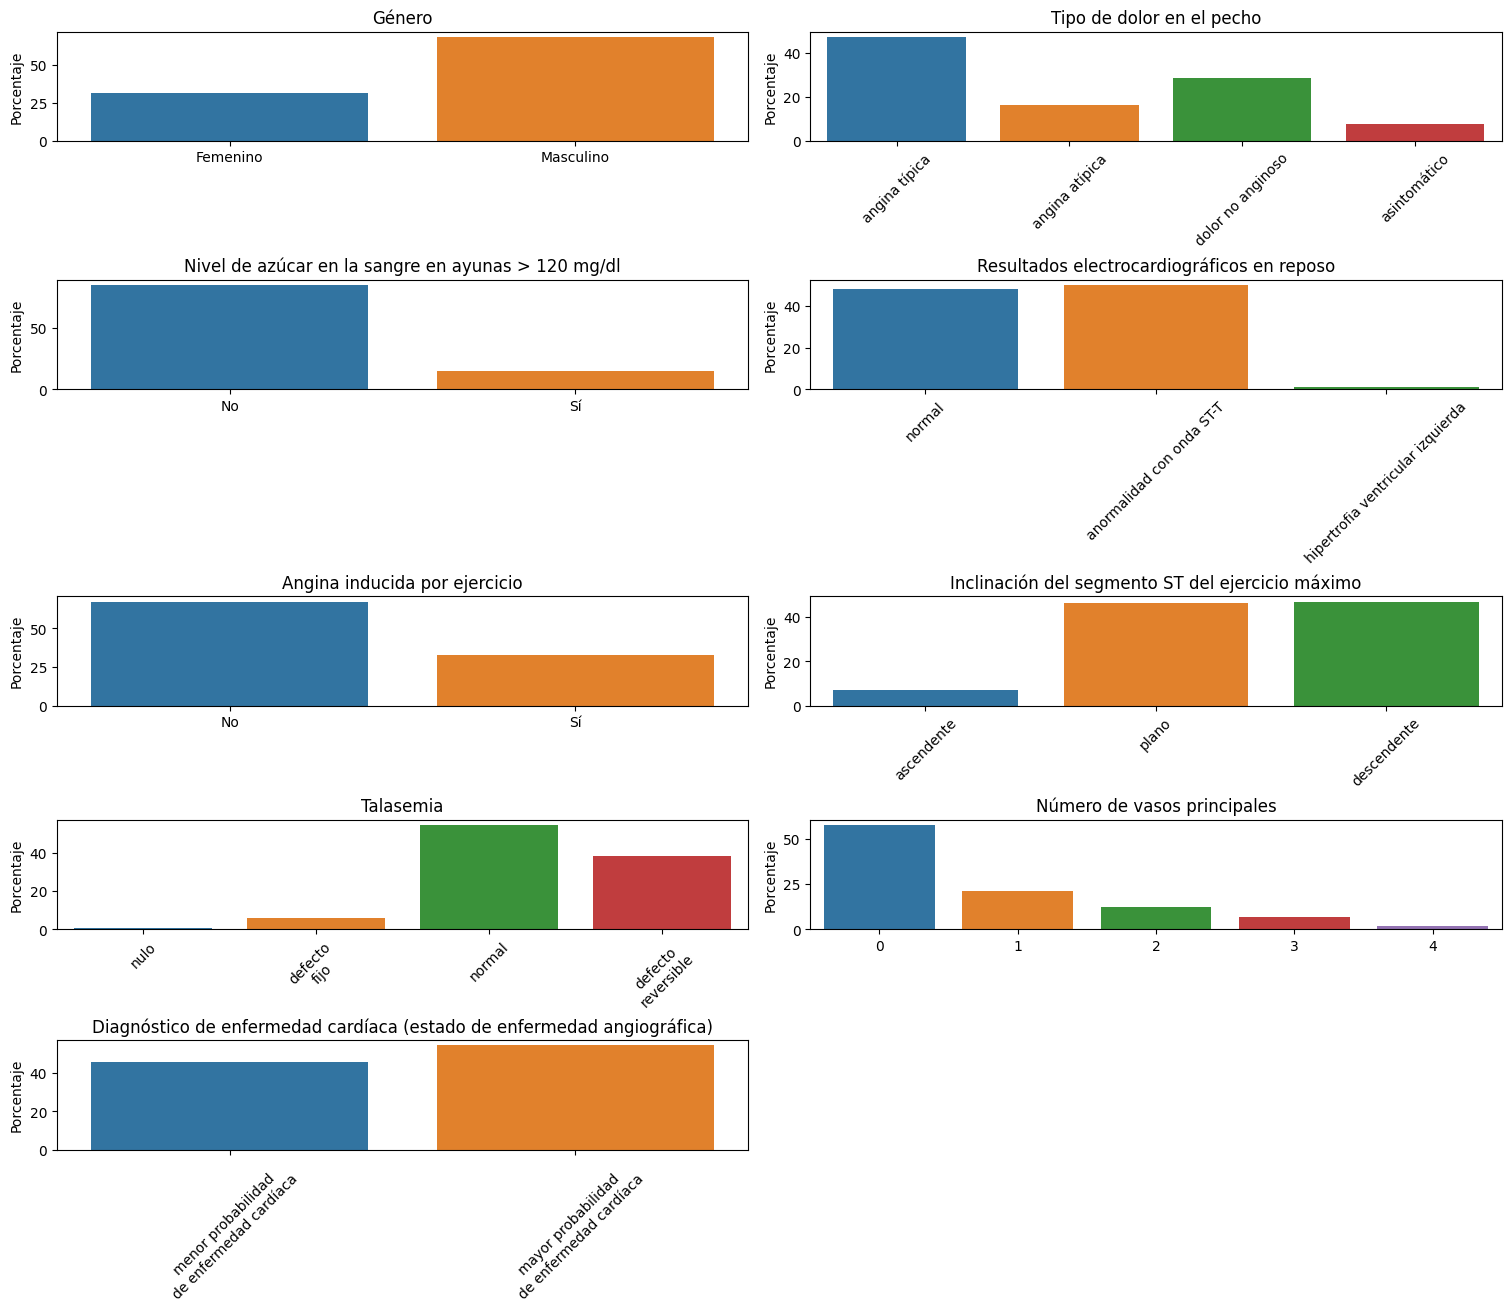

In [6]:
#Variables categóricas
fig = plt.figure(figsize=(15, 13), constrained_layout=True)

#Sexo
ax0 = fig.add_subplot(5,2,1)
counts = df['sex'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index, y=counts, ax=ax0)
ax0.set_xticklabels(['Femenino', 'Masculino'], rotation=0)
ax0.set_ylabel("Porcentaje")
ax0.set_title('Género')

#Tipo de dolor en el pecho
ax1 = fig.add_subplot(5,2,2)
counts = df['cp'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index, y=counts, ax=ax1)
ax1.set_xticklabels(['angina típica', 'angina atípica', 'dolor no anginoso', 'asintomático'], rotation=45)
ax1.set_ylabel("Porcentaje")
ax1.set_title('Tipo de dolor en el pecho')

#Nivel de azúcar en la sangre en ayunas > 120 mg/dl
ax2 = fig.add_subplot(5,2,3)
counts = df['fbs'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index, y=counts, ax=ax2)
ax2.set_xticklabels(['No', 'Sí'], rotation=0)
ax2.set_ylabel("Porcentaje")
ax2.set_title('Nivel de azúcar en la sangre en ayunas > 120 mg/dl')

#Resultados electrocardiográficos en reposo
ax3 = fig.add_subplot(5,2,4)
counts = df['restecg'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax3)
ax3.set_xticklabels(['normal', 'anormalidad con onda ST-T', 'hipertrofia ventricular izquierda'], rotation=45)
ax3.set_ylabel("Porcentaje")
ax3.set_title('Resultados electrocardiográficos en reposo')

#Angina inducida por ejercicio
ax4 = fig.add_subplot(5,2,5)
counts = df['exng'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax4)
ax4.set_xticklabels(['No', 'Sí'], rotation=0)
ax4.set_ylabel("Porcentaje")
ax4.set_title('Angina inducida por ejercicio')

#Inclinación del segmento ST del ejercicio máximo
ax5 = fig.add_subplot(5,2,6)
counts = df['slp'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax5)
ax5.set_xticklabels(['ascendente', 'plano', 'descendente'], rotation=45)
ax5.set_ylabel("Porcentaje")
ax5.set_title('Inclinación del segmento ST del ejercicio máximo')

#Thalassemia
ax6 = fig.add_subplot(5,2,7)
counts = df['thall'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax6)
ax6.set_xticklabels(['nulo', 'defecto\nfijo', 'normal', 'defecto\nreversible'], rotation=45)
ax6.set_ylabel("Porcentaje")
ax6.set_title('Talasemia')

#Diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfica)
ax4 = fig.add_subplot(5,2,9)
counts = df['output'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax4)
ax4.set_xticklabels(['menor probabilidad\nde enfermedad cardíaca', 'mayor probabilidad\nde enfermedad cardíaca'], rotation=45)
ax4.set_ylabel("Porcentaje")
ax4.set_title('Diagnóstico de enfermedad cardíaca (estado de enfermedad angiográfica)')

#Número de vasos principales
ax4 = fig.add_subplot(5,2,8)
counts = df['caa'].value_counts(normalize=True, sort=False) * 100
sns.barplot(x=counts.index,
y=counts, ax=ax4)
ax4.set_xticklabels(['0','1', '2', '3', '4'], rotation=0)
ax4.set_ylabel("Porcentaje")
ax4.set_title('Número de vasos principales')

plt.show()

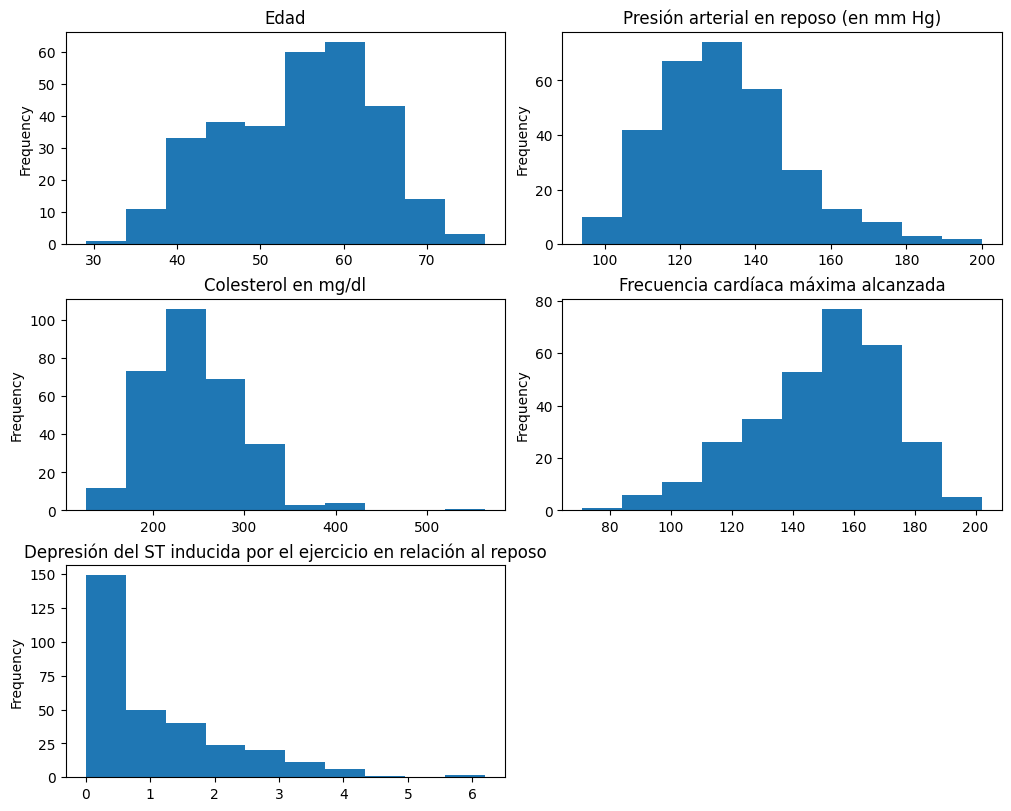

In [7]:
#Variables numéricas
#Graficando datos cuantitativos
fig = plt.figure(figsize=(10,8), constrained_layout=True)

ax0 = fig.add_subplot(3,2,1)
df.age.plot.hist(ax=ax0)
ax0.set_title('Edad')

ax1 = fig.add_subplot(3,2,2)
df.trtbps.plot.hist(ax=ax1)
ax1.set_title('Presión arterial en reposo (en mm Hg)')

ax3 = fig.add_subplot(3,2,3)
df.chol.plot.hist(ax=ax3)
ax3.set_title('Colesterol en mg/dl')

ax4 = fig.add_subplot(3,2,4)
df.thalachh.plot.hist(ax=ax4)
ax4.set_title('Frecuencia cardíaca máxima alcanzada')

ax5 = fig.add_subplot(3,2,5)
df.oldpeak.plot.hist(ax=ax5)
ax5.set_title('Depresión del ST inducida por el ejercicio en relación al reposo')

plt.show()

También es necesario ver las correlaciones entre las varibales para identificar patrones.

<AxesSubplot: >

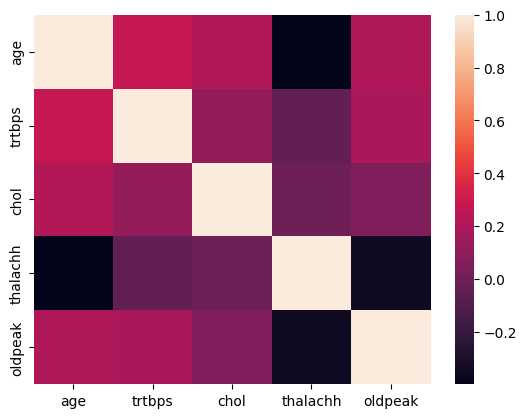

In [ ]:
# Visualizando correlaciones
corr = df[numeric].corr()
sns.heatmap(corr)

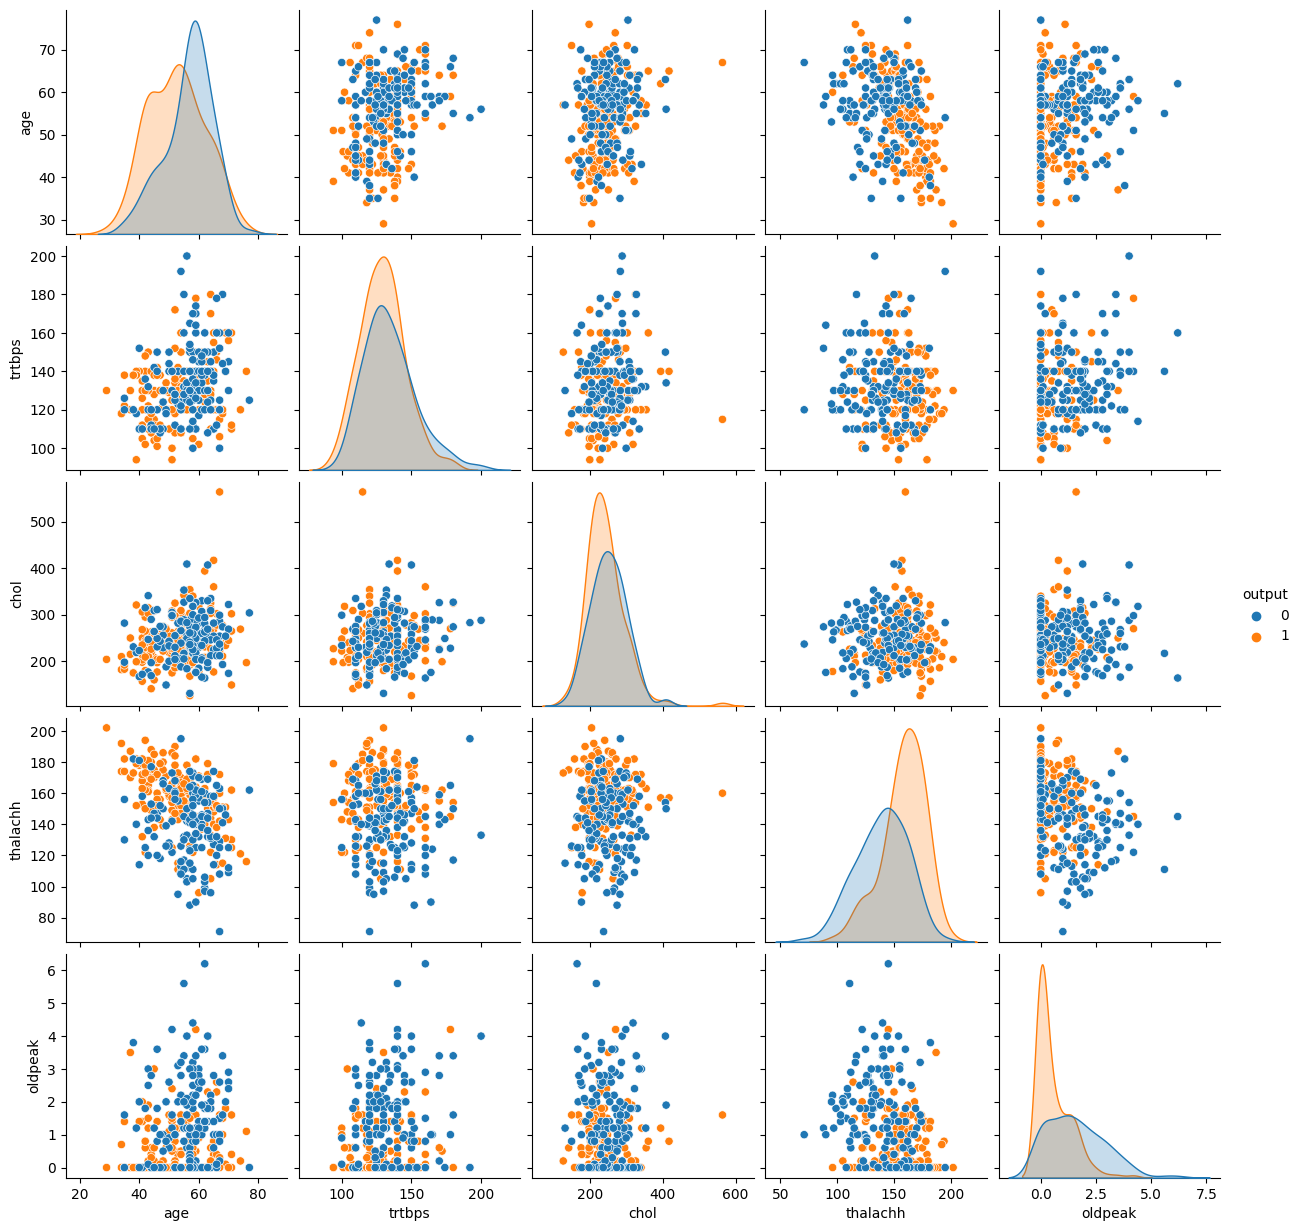

In [ ]:
sns.pairplot(df[numeric + ['output']], hue='output')

#### Modelado

Luego de la exploración inicial de datos, se procede a construir los modelos. En este caso se probarán tres arquitecturas diferentes. La primera con una, la segunda con dos y la última capas ocultas.

El primer paso es el pre-procesamiento de los datos. Inicialmente se separa en train set y test set, luego, según el tipo de varible, se normaliza, se escala, o se aplica one hot encoding.

In [8]:
# Prepocesando los datos usando sklearn
from sklearn.model_selection import train_test_split

X = df.drop('output', axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) 

In [59]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


numeric = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
ordinal = ['caa']
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exng', 'slp', 'thall']

numeric_transformer = Pipeline([('inputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())
                               ])
cat_transformer = Pipeline([('inputer', SimpleImputer(strategy='most_frequent')),
                             ('onehot', OneHotEncoder())
                            ])
ordinal_transformer = Pipeline([('inputer', SimpleImputer(strategy='most_frequent')),
                               ('ord_encod', OrdinalEncoder())
                               ])

preprocessor = ColumnTransformer([('num', numeric_transformer, numeric),
                                ('ordinal', ordinal_transformer, ordinal),
                                ('cat', cat_transformer, categorical),
                                ])

scaler = preprocessor.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

# X preserves ther order in which the variables were fed to the transformer
df_transf = pd.DataFrame(X_train_trans)

In [60]:
# Dando nombre a las columnas
def get_column_names(column_transformer):
  features_names =[]
  for key, value in column_transformer.named_transformers_.items():
    features = list(value.get_feature_names_out())
    features_names.extend(features)
  return features_names

In [62]:
df_transf.columns = get_column_names(preprocessor)
df_transf.head(3)

,age,trtbps,chol,thalachh,oldpeak,caa,sex_0,sex_1,cp_0,cp_1,...,restecg_2,exng_0,exng_1,slp_0,slp_1,slp_2,thall_0,thall_1,thall_2,thall_3
0,1.785685,-1.306531,0.376942,-0.843894,-0.893360,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-1.135510,-0.694410,-1.434515,-0.242820,1.493222,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.702740,-0.082290,0.565635,-0.457489,-0.722890,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


Una vez las variables están preprocesadas, se puede iniciar la construcción de los modelos. 


##### Modelo con una capa oculta

Se construye el primer modelo, este consta de una capa oculta. Para encontrar los hyperparametros más óptimos, se utiliza Grid Search con Cross Validation. Para tal efecto, la libreria Scikeras permite usar la función GridSearchCV de SciKit-learn en modelos construidos en Keras.

In [68]:
from scikeras.wrappers import KerasClassifier, KerasRegressor

def create_model_grid(activation='relu', optimizer='rmsprop', neurons=20):
    model = Sequential()
    model.add(Dense(neurons, input_dim=26, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

model_grid = KerasClassifier(model=create_model_grid, activation='relu', neurons=10, #add parameters from model not included in KerasClassifier
                        epochs=10, 
                        batch_size=32, 
                        verbose=0)

In [69]:
activations = ['tanh','relu','sigmoid']
neurons = [10,15,20,26,30,35]

param_grid = dict(activation=activations, 
                  neurons=neurons)

In [72]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model_grid, 
                    param_grid=param_grid,
                    cv = 4,
                    verbose=1)

In [73]:
grid = grid.fit(X_train_trans, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


In [74]:
# Results
print('best cv score : ', grid.best_score_)
print('best hyperparameters : ', grid.best_params_)
print('score for test set : ', grid.score(X_test_trans, y_test))

best cv score :  0.8066037735849058
best hyperparameters :  {'activation': 'tanh', 'neurons': 35}
score for test set :  0.8241758241758241


In [86]:
# Double checking the KerasClassifier object
model = grid.best_estimator_
model_training_score = model.score(X_train_trans, y_train)
model_test_score = model.score(X_test_trans, y_test)
print(model_test_score)

0.8241758241758241


##### Modelo con dos capas ocultas

Se repite el procedimiento, pero ahora para dos capas ocultas.

In [82]:
# Second model: two hidden layers
def create_model_grid(activation='relu', neurons_l1=20, neurons_l2=20):
    model = Sequential()
    model.add(Dense(neurons_l1, input_dim=26, activation=activation))
    model.add(Dense(neurons_l2, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_grid_1 = KerasClassifier(model=create_model_grid, activation='relu', neurons_l1=20, neurons_l2=20,
                        batch_size=32, 
                        verbose=0)

In [83]:
activations = ['tanh','relu','sigmoid']
neurons_l1 = [10,15,20,26,30]
neurons_l2 = [10,15,20,26,30]

param_grid_1 = dict(activation=activations, 
                  neurons_l1=neurons_l1,
                 neurons_l2=neurons_l2)

In [85]:
grid_1 = GridSearchCV(estimator=model_grid_1, 
                    param_grid=param_grid_1,
                    cv = 4,
                    verbose=1)

grid_1 = grid_1.fit(X_train_trans, y_train)

Fitting 4 folds for each of 75 candidates, totalling 300 fits


In [87]:
# Results
print('best cv score : ', grid_1.best_score_)
print('best hyperparameters : ', grid_1.best_params_)
print('score for test set : ', grid_1.score(X_test_trans, y_test))

best cv score :  0.7169811320754718
best hyperparameters :  {'activation': 'tanh', 'neurons_l1': 26, 'neurons_l2': 10}
score for test set :  0.7582417582417582


In [88]:
#Double checking the KerasClassifier object
model_1 = grid_1.best_estimator_
model_1_training_score = model_1.score(X_train_trans, y_train)
model_1_test_score = model_1.score(X_test_trans, y_test)
print(model_1_test_score)

0.7582417582417582


##### Modelo con tres capas ocultas

Finalmente, se entrena un modelo con tres capas ocultas. De nuevo, se utiliza grid search para encontrar los mejores hiperparametros

In [89]:
#Repeating with three hidden layers
def create_model_grid(activation='relu', neurons_l1=20, neurons_l2=20, neurons_l3=20):
    model = Sequential()
    model.add(Dense(neurons_l1, input_dim=26, activation=activation))
    model.add(Dense(neurons_l2, activation=activation))
    model.add(Dense(neurons_l3, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', metrics=['accuracy'])
    return model

model_grid_2 = KerasClassifier(model=create_model_grid, activation='relu', neurons_l1=20, neurons_l2=20, neurons_l3=20,
                        batch_size=32, 
                        verbose=0)

In [90]:
activations = ['tanh','relu','sigmoid']
neurons_l1 = [10,15,20,26,30]
neurons_l2 = [10,15,20,26,30]
neurons_l3 = [10,15,20,26,30]

param_grid_2 = dict(activation=activations, 
                  neurons_l1=neurons_l1,
                  neurons_l2=neurons_l2,
                  neurons_l3=neurons_l3)

In [91]:
from sklearn.model_selection import GridSearchCV

grid_2 = GridSearchCV(estimator=model_grid_2, 
                    param_grid=param_grid_2,
                    cv = 4,
                    verbose=1)

grid_2 = grid_2.fit(X_train_trans, y_train)

Fitting 4 folds for each of 375 candidates, totalling 1500 fits


In [92]:
#Results
print('best cv score : ', grid_2.best_score_)
print('best hyperparameters : ', grid_2.best_params_)
print('score for test set : ', grid_2.score(X_test_trans, y_test))

best cv score :  0.7735849056603774
best hyperparameters :  {'activation': 'tanh', 'neurons_l1': 15, 'neurons_l2': 26, 'neurons_l3': 15}
score for test set :  0.6703296703296703


In [93]:
# Double checking the KerasClassifier object
model_2 = grid_2.best_estimator_
model_2_training_score = model_2.score(X_train_trans, y_train)
model_2_test_score = model_2.score(X_test_trans, y_test)
print(model_2_test_score)

0.6703296703296703


#### Evaluación de los Resultados

Con los mejores modelos de cada arquitectura, es posible compararlos y seleccionar el mejor. La métrica utilizada es "accuracy" del test set, esta es indicativa del desempeño del modelo cuando se tiene un conjunto de datos con las categorias balanceadas.

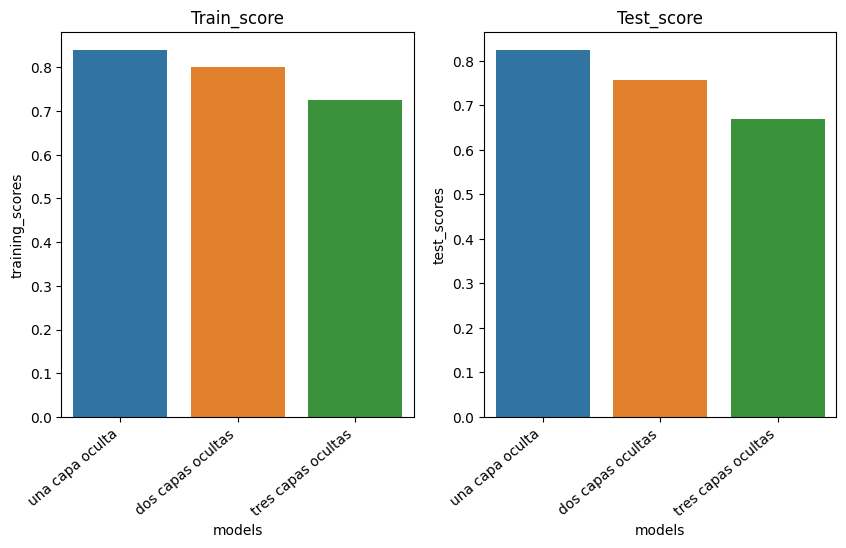

In [94]:
models = ['una capa oculta', 'dos capas ocultas', 'tres capas ocultas']
test_scores = [model_test_score, model_1_test_score, model_2_test_score]
training_scores = [model_training_score, model_1_training_score, model_2_training_score]

df_scores = pd.DataFrame({'models' : models,
                         'test_scores' : test_scores,
                         'training_scores' : training_scores})

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
sns.barplot(x='models', y='training_scores', ax=ax1, data=df_scores)
sns.barplot(x='models', y='test_scores', ax=ax2, data=df_scores)

# set titles for plots
ax1.set_title("Train_score")
ax2.set_title("Test_score")

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=40, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=40, ha="right")

# display the plots
plt.show()

Se puede ver que el modelo con una capa oculta es el que mejor se desempeña en el test set bajo la métrica "accuracy". Este modelo tiene la función *tanh* como función de activación en la capa oculta y consta de 35 neuronas en la misma.

In [95]:
grid.best_params_

{'activation': 'tanh', 'neurons': 35}

#### Feature Importance

Una vez escogido el mejor modelo, se procede a interpretarlo. Dada la complejidad de los modelos de Deep Learning, su explicación no se puede realizar de forma directa y para ello se utilizan diferentes técnicas. Lo que se desea conocer es la importancia de cada variable de entrada ("features") al momento de hacer la predicción. En este caso se usa la técnica de permutación. Esta consiste en permutar los valores de las filas de cada columna, una columna a la vez, y calcular como el desempeño es afectado por esta permutación. Aquellas columnas (esto es, las variables) cuya permutación cause la mayor caída en el desepeño serán las mas importantes para el modelo. 

El resultado es diferente, ya sea se use el test o training set,  por lo que se debe evaluar para ambos conjuntos de datos.

Primero, se visualiza para el train set.

In [96]:
#Feature importance using permutation for train set
from sklearn.inspection import permutation_importance
r = permutation_importance(model, X_train_trans, y_train,
                           n_repeats=30,
                           random_state=0)

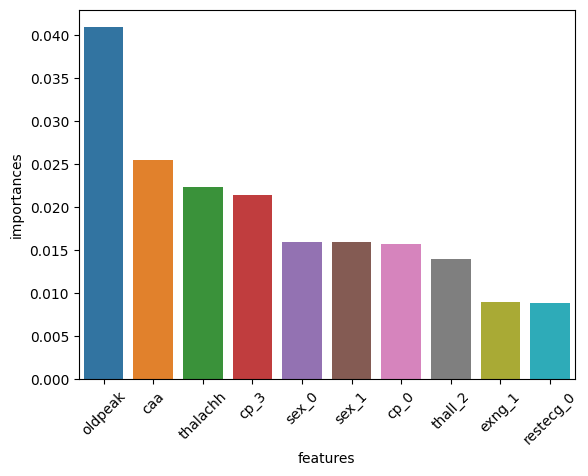

In [100]:
feature_names = get_column_names(preprocessor)

model_importances = pd.DataFrame({'features' : feature_names,
                                 'importances' : r.importances_mean,
                                 'std_importances' : r.importances_std})

model_importances = model_importances.sort_values(by='importances', ascending=False).reset_index().head(10)

fig, ax = plt.subplots()
sns.barplot(x='features', y='importances', data=model_importances)
ax.set_xticklabels(labels=model_importances.features, rotation=45)
plt.show()

Ahora, para el test set.

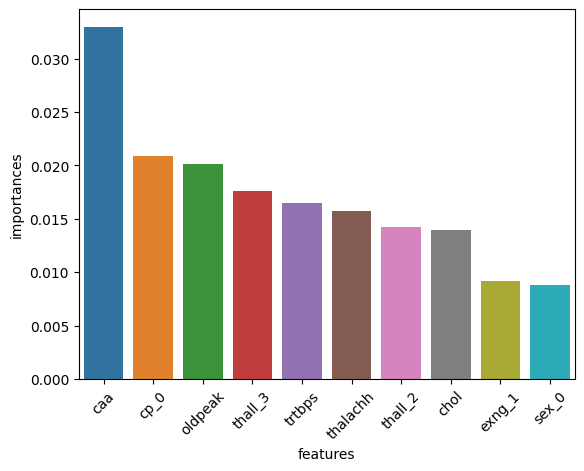

In [101]:
#feature importance for test set
r = permutation_importance(model, X_test_trans, y_test,
                           n_repeats=30,
                           random_state=0)

model_importances = pd.DataFrame({'features' : feature_names,
                                 'importances' : r.importances_mean,
                                 'std_importances' : r.importances_std})

model_importances = model_importances.sort_values(by='importances', ascending=False).reset_index().head(10)

fig, ax = plt.subplots()
sns.barplot(x='features', y='importances', data=model_importances)
ax.set_xticklabels(labels=model_importances.features, rotation=45)
#ax.set_title('Test set')
plt.show()

En ambos casos, caa (número de vasos principales) es una varible muy importante. También se puede ver que oldpeak (depresión de ST inducida por ejercicio en relación con el reposo) es una variable muy importante cuando se usa el training set, pero no con el test set. Esto puede ser una señal de que esta varible esta causando overfitting. Finalmente, cp_0 (tipo de dolor de pecho. Valor 0: angina típica) es muy importante en el test set, pero no así cuando se usa en training set. Esto sugiere que el modelo puede no estar capturando parte de la complejidad en los datos.

#### Conclusiones

El modelo que mejor se desempeña con la métrica escogida es el de arquitectura más simple. Sin embargo, todavía es posible mejorar este modelo buscando hiperparámetros más óptimos utilizando "Grid Search".